## Сбор данных (создание веб-краулера) с сайта "Яндекс Дзен"

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
from datetime import datetime, timedelta
from sqlalchemy import create_engine
import traceback

cookies = {
    'news_lang': 'ru',
    'nc': 'tips=1669116675432%3Bfavorites-button:1',
    'sso_checked': '1',
    'yandex_login': '',
    'yandexuid': '4418883751668766953',
    '_yasc': 'bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=',
    '_ym_uid': '16687727324320845',
    '_ym_d': '1668772732',
    'vid': 'c4a038b4868be81c',
    'Session_id': 'noauth:1669019784',
    'mda2_beacon': '1669019784785',
    '_ym_isad': '2',
    'tmr_lvid': '52390132f1b93bbd91c4c20fb582a7b7',
    'tmr_lvidTS': '1668772731725',
    'tmr_detect': '0%7C1669277547765',
}

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
    # Requests sorts cookies= alphabetically
    # 'Cookie': 'news_lang=ru; nc=tips=1669116675432%3Bfavorites-button:1; sso_checked=1; yandex_login=; yandexuid=4418883751668766953; _yasc=bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=; _ym_uid=16687727324320845; _ym_d=1668772732; vid=c4a038b4868be81c; Session_id=noauth:1669019784; mda2_beacon=1669019784785; _ym_isad=2; tmr_lvid=52390132f1b93bbd91c4c20fb582a7b7; tmr_lvidTS=1668772731725; tmr_detect=0%7C1669277547765',
    'Referer': 'https://dzen.ru/news?issue_tld=ru',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
}

# Функция для обработки и вывода времени
def parse_date(s_date):
    months = {'января': '01',
              'февраля': '02',
              'марта': '03',
              'апреля': '04',
              'мая': '05',
              'июня': '06',
              'июля': '07',
              'августа': '08',
              'сентября': '09',
              'октября': '10',
              'ноября': '11',
              'декабря': '12',
              }
    
    row_date = s_date.split(' в')[0]
    month_ = row_date.split(' ')[1].strip(' ')
    date_num = re.search(r'\d{2}', row_date).group(0)
    date = f"{date_num}.{months[month_]}.2022"
    return date

### Сбор новостей по рубрикам

In [2]:
def parse_rubrics():
    rubrics = ['Политика', 'Армия и оружие', 'Общество', 'ЖКХ', 'Религия', 'Экология', 'Здоровье', 'Путешествия', 
               'Транспорт', 'Экономика', 'Энергетика', 'Недвижимость', 'Финансы', 'В мире', 'Спорт', 'Автоспорт',
               'Баскетбол', 'Футбол', 'Хоккей', 'Фигурное катание', 'Происшествия', 'Культура', 'Театры', 'Музыка',
               'Кино', 'Технологии', 'Игры', 'Гаджеты', 'Интернет', 'Наука', 'Космос']
    rubrics_links = ['rubric/politics', 'rubric/army', 'rubric/society', 'rubric/communal', 'rubric/religion',
                     'rubric/ecology', 'rubric/health', 'rubric/travels', 'rubric/vehicle',  'rubric/business',
                     'rubric/energy', 'rubric/realty', 'rubric/finances', 'rubric/world', 'rubric/sport',
                     'rubric/auto_racing', 'rubric/basketball', 'rubric/football', 'rubric/hockey',
                     'rubric/figure_skating', 'rubric/incident', 'rubric/culture', 'rubric/theaters',
                     'rubric/music', 'rubric/movies', 'rubric/computers', 'rubric/games', 'rubric/gadgets',
                     'rubric/internet', 'rubric/science', 'rubric/cosmos']

    rubricsAndLinks = list(zip(rubrics, rubrics_links))
    df_rubricsAndLinks = pd.DataFrame(rubricsAndLinks, columns=['rubric', 'rubric_link'])

    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    dates = []
    times = []
    data = []
    stories = []

    for i, row in df_rubricsAndLinks.iterrows():
        link = row['rubric_link']
        r = session.get(f'https://dzen.ru/news/{link}?issue_tld=ru')

        soup = BeautifulSoup(r.text)
        script_text = soup.find_all('script')[3].contents[0]
        data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", script_text, flags=re.S).group(1))

        story_rubric = row['rubric']
    
        for stories_top in data['news']['top']:
        
            story_id = stories_top['id']
            story_title = stories_top['title']
            story_annotation = stories_top['annotation']
            story_url = stories_top['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_top['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
        for stories_feed in data['news']['feed']:
        
            story_id = stories_feed['id']
            story_title = stories_feed['title']
            story_annotation = stories_feed['annotation']
            story_url = stories_feed['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_feed['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
    
    story_headers = ['rubric', 'id', 'title', 'annotation', 'story_url', 'instory_url', 'time']
    df_stories = pd.DataFrame(stories, columns=story_headers)

    return df_stories

### Сбор похожих новостей при переходе к каждой новости (instory)

In [3]:
def parse_main():
    df_stories = parse_rubrics()
    df_instory = df_stories[['rubric', 'id', 'instory_url']]
    more_stories = []
    
    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    for i, row in df_stories.iterrows():
        url = row['instory_url']
        more = session.get(url)
        more_soup = BeautifulSoup(more.text)
        more_script_text = more_soup.find_all('script')[3].contents[0]
        more_data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", more_script_text, flags=re.S).group(1))
                               
        more_info = more_data['news']['instoryPage'][0]
        docs = more_info['docs']
    
        more_rubric = row['rubric']
        more_idMain = row['id']
        more_instoryUrl = row['instory_url']
            
        for doc in docs:
        
            more_id = doc['docId']
            more_title = doc['title'][0]['text']  
            more_text = doc['text'][0]['text'] 
            more_source = doc['sourceName']
            more_url = doc['url']
            more_time = doc['time']
            if 'вчера' in more_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', more_time) is not None:
                date = parse_date(more_time)
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
   
            more_stories.append([more_rubric, more_idMain, more_title, more_text, more_source, more_instoryUrl, more_url, more_time])
            
    more_stories_headers = ['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url', 'url', 'time']
    df_more_stories = pd.DataFrame(more_stories, columns=more_stories_headers)
    
    main_rubrics = []
    for i, row in df_more_stories.iterrows():
        if row['rubric'] == 'Политика' or row['rubric'] == 'Армия и оружие':
            main_rubric = 'Политика'
        elif row['rubric'] == 'Общество' or row['rubric'] == 'ЖКХ' or row['rubric'] == 'Религия' or row['rubric'] == 'Экология' or row['rubric'] == 'Здоровье' or row['rubric'] == 'Путешествия' or row['rubric'] == 'Транспорт':
            main_rubric = 'Общество'
        elif row['rubric'] == 'Экономика' or row['rubric'] == 'Энергетика' or row['rubric'] == 'Недвижимость' or row['rubric'] == 'Финансы':
            main_rubric = 'Экономика'
        elif row['rubric'] == 'В мире':
            main_rubric = 'В мире'
        elif row['rubric'] == 'Спорт' or row['rubric'] == 'Автоспорт' or row['rubric'] == 'Баскетбол' or row['rubric'] == 'Футбол' or row['rubric'] == 'Хоккей' or row['rubric'] == 'Фигурное катание':
            main_rubric = 'Спорт'
        elif row['rubric'] == 'Происшествия':
            main_rubric = 'Происшествия'
        elif row['rubric'] == 'Культура' or row['rubric'] == 'Театры' or row['rubric'] == 'Музыка' or row['rubric'] == 'Кино':
            main_rubric = 'Культура'
        elif row['rubric'] == 'Технологии' or row['rubric'] == 'Игры' or row['rubric'] == 'Гаджеты' or row['rubric'] == 'Интернет':
            main_rubric = 'Технологии'
        elif row['rubric'] == 'Наука' or row['rubric'] == 'Космос':
            main_rubric = 'Наука'
        else:
            main_rubric = 'Другое'
        
        main_rubrics.append(main_rubric)
                             
    df_more_stories.insert(loc=0, column='main_rubric', value=main_rubrics)
    return df_more_stories

## Разведочный анализ данных

In [4]:
%%time
df_parse = parse_main()
df_nlp = df_parse.loc[:, ['main_rubric','rubric','title','text']]

#df_nlp

CPU times: user 33.4 s, sys: 1.78 s, total: 35.1 s
Wall time: 2min 59s


In [5]:
# Информация о данных
df_nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3744 entries, 0 to 3743
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   main_rubric  3744 non-null   object
 1   rubric       3744 non-null   object
 2   title        3744 non-null   object
 3   text         3744 non-null   object
dtypes: object(4)
memory usage: 117.1+ KB


In [6]:
# Кол-во пропусков во всем датафрейме
df_nlp.isnull().sum()

main_rubric    0
rubric         0
title          0
text           0
dtype: int64

<div class="alert alert-success"><b>Пропусков в данных нет</b>

In [7]:
# Статистика распределения значений в столбце rubric в % виде
df_nlp['rubric'].value_counts(normalize=True)

Происшествия        0.146368
Армия и оружие      0.047276
Здоровье            0.037660
Политика            0.035524
Общество            0.034989
В мире              0.034722
Наука               0.033387
Путешествия         0.033387
Культура            0.032585
Экономика           0.032051
Хоккей              0.030716
Транспорт           0.030449
Спорт               0.030449
Футбол              0.029915
Финансы             0.029915
Космос              0.029647
Музыка              0.029113
Технологии          0.029113
Энергетика          0.028846
Гаджеты             0.028579
Кино                0.028045
ЖКХ                 0.028045
Игры                0.026442
Фигурное катание    0.026175
Недвижимость        0.024840
Театры              0.020566
Автоспорт           0.020566
Баскетбол           0.020299
Интернет            0.017895
Религия             0.015759
Экология            0.006677
Name: rubric, dtype: float64

In [8]:
# Статистика распределения этих значений в столбце main_rubric в % виде
df_nlp['main_rubric'].value_counts(normalize=True)

Общество        0.186966
Спорт           0.158120
Происшествия    0.146368
Экономика       0.115652
Культура        0.110310
Технологии      0.102030
Политика        0.082799
Наука           0.063034
В мире          0.034722
Name: main_rubric, dtype: float64

In [9]:
# Исследование столбца rubric
print('Кол-во уникальных значений: ', df_nlp['rubric'].nunique())
print('Список уникальных значений: ', df_nlp['rubric'].unique())
print('Статистика распределения значений: ', df_nlp['rubric'].value_counts(normalize=False))

Кол-во уникальных значений:  31
Список уникальных значений:  ['Политика' 'Армия и оружие' 'Общество' 'ЖКХ' 'Религия' 'Экология'
 'Здоровье' 'Путешествия' 'Транспорт' 'Экономика' 'Энергетика'
 'Недвижимость' 'Финансы' 'В мире' 'Спорт' 'Автоспорт' 'Баскетбол'
 'Футбол' 'Хоккей' 'Фигурное катание' 'Происшествия' 'Культура' 'Театры'
 'Музыка' 'Кино' 'Технологии' 'Игры' 'Гаджеты' 'Интернет' 'Наука' 'Космос']
Статистика распределения значений:  Происшествия        548
Армия и оружие      177
Здоровье            141
Политика            133
Общество            131
В мире              130
Наука               125
Путешествия         125
Культура            122
Экономика           120
Хоккей              115
Транспорт           114
Спорт               114
Футбол              112
Финансы             112
Космос              111
Музыка              109
Технологии          109
Энергетика          108
Гаджеты             107
Кино                105
ЖКХ                 105
Игры                 99
Фигур

In [10]:
# Исследование столбца main_rubric
print('Кол-во уникальных значений: ', df_nlp['main_rubric'].nunique())
print('Список уникальных значений: ', df_nlp['main_rubric'].unique())
print('Статистика распределения значений: ', df_nlp['main_rubric'].value_counts(normalize=False))

Кол-во уникальных значений:  9
Список уникальных значений:  ['Политика' 'Общество' 'Экономика' 'В мире' 'Спорт' 'Происшествия'
 'Культура' 'Технологии' 'Наука']
Статистика распределения значений:  Общество        700
Спорт           592
Происшествия    548
Экономика       433
Культура        413
Технологии      382
Политика        310
Наука           236
В мире          130
Name: main_rubric, dtype: int64


<div class="alert alert-success"><b>Вывод: вид задачи - многоклассовая классификация</b>

In [11]:
# Описательная статистика для всех признаков 
df_nlp.describe().T

,count,unique,top,freq
main_rubric,3744,9,Общество,700
rubric,3744,31,Происшествия,548
title,3744,3296,Экономист высказался по поводу роста курса евр...,8
text,3744,3338,Такое заявление сделал начальник департамента ...,6


### Визульный анализ

<AxesSubplot:>

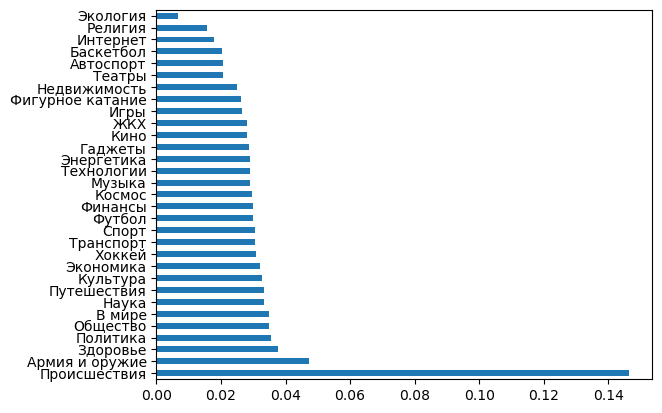

In [12]:
# Горизонтальная столбчатая диаграмма для столбца rubric
df_nlp['rubric'].value_counts(normalize=True).plot.barh()

<AxesSubplot:>

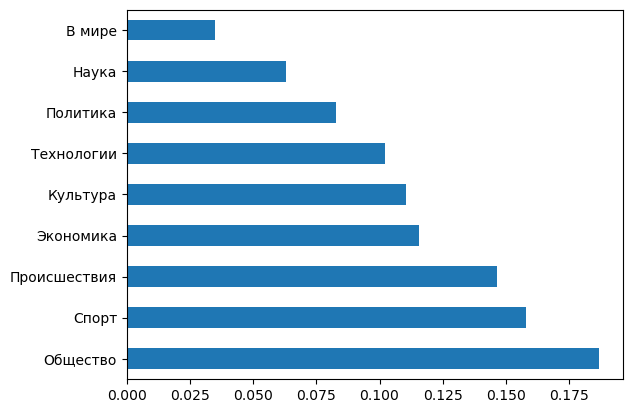

In [13]:
# Горизонтальная столбчатая диаграмма для столбца main_rubric
df_nlp['main_rubric'].value_counts(normalize=True).plot.barh()

In [14]:
df_nlp['rubric'].value_counts()

Происшествия        548
Армия и оружие      177
Здоровье            141
Политика            133
Общество            131
В мире              130
Наука               125
Путешествия         125
Культура            122
Экономика           120
Хоккей              115
Транспорт           114
Спорт               114
Футбол              112
Финансы             112
Космос              111
Музыка              109
Технологии          109
Энергетика          108
Гаджеты             107
Кино                105
ЖКХ                 105
Игры                 99
Фигурное катание     98
Недвижимость         93
Театры               77
Автоспорт            77
Баскетбол            76
Интернет             67
Религия              59
Экология             25
Name: rubric, dtype: int64

In [15]:
df_nlp['main_rubric'].value_counts()

Общество        700
Спорт           592
Происшествия    548
Экономика       433
Культура        413
Технологии      382
Политика        310
Наука           236
В мире          130
Name: main_rubric, dtype: int64

## Обработка естественного языка NLP

Действия, выполняемые в процессе:

* удаление пробельных символов;
* стемминг;
* удаление стоп-слов;
* лемматизация.

In [35]:
# Функция для удаления пробельных символов
import string
import re
from nltk.corpus import stopwords

def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

def delete_char(): 
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in df_nlp['text']]
    prep_title = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in df_nlp['title']]
    df_nlp["text_prep"] = prep_text
    df_nlp["title_prep"] = prep_title
    return df_nlp


#Функция для стемматизации
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

def stemmed_text():
    stemmer = SnowballStemmer("russian")
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])

    stemmed_texts_list = []
    stemmed_titles_list = []
    
    for text in df_nlp["text_prep"]:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
        text = " ".join(stemmed_tokens)
        stemmed_texts_list.append(text)
    
    df_nlp["text_stem"] = stemmed_texts_list
    
    for text in df_nlp["title_prep"]:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
        text = " ".join(stemmed_tokens)
        stemmed_titles_list.append(text)
    
    df_nlp["title_stem"] = stemmed_titles_list
    
    return df_nlp


#Функция для удаления стоп-слов
from nltk import word_tokenize

def stopword_text():
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])
    
    sw_texts_list = []
    sw_titles_list = []
    
    for text in df_nlp['text_prep']:
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
        text = " ".join(tokens)
        sw_texts_list.append(text)

    df_nlp["text_sw"] = sw_texts_list
    
    for text in df_nlp['title_prep']:
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
        text = " ".join(tokens)
        sw_titles_list.append(text)
        
    df_nlp["title_sw"] = sw_titles_list
    
    return df_nlp


#Функция для лемматизации
from pymystem3 import Mystem

def lemmatize_text():
    mystem = Mystem()
    
    lemm_texts_list = []
    lemm_titles_list = []
    
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])
    text1 = ""
    text2 = ""

    text_list = df_nlp['text_sw'].to_list()
    text_join = "joining".join(text_list)
    
    title_list = df_nlp['title_sw'].to_list()
    title_join = "joining".join(title_list)

    try:
        text_lem = mystem.lemmatize(text_join)
        tokens1 = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text1 = " ".join(tokens1)
        
        title_lem = mystem.lemmatize(title_join)
        tokens2 = [token for token in title_lem if token != ' ' and token not in russian_stopwords]
        text2 = " ".join(tokens2)
        
    except Exception as e:
        print(e)

    text1_split = text1.split("joining")
    df_nlp["text_lemm"] = text1_split
    text2_split = text2.split("joining")
    df_nlp["title_lemm"] = text2_split
    
    return df_nlp

    
#Функция для балансировки классов
def nlp(df):
    df_pr = df.loc[df['main_rubric'] == 'Происшествия'].head(200)
    df_other = df.loc[df['main_rubric'] != 'Происшествия']
    df = pd.concat([df_pr, df_other])
    return df

In [34]:
df_nlp = nlp(df_nlp)
df_nlp

,main_rubric,rubric,title,text,text_prep,title_prep,text_stem,title_stem,text_sw,title_sw,text_lemm,title_lemm
2165,Происшествия,Происшествия,По обвинению во взяточничестве арестованы подм...,Под следствие попал глава аналитического отдел...,под следствие попал глава аналитического отдел...,по обвинению во взяточничестве арестованы подм...,следств попа глав аналитическ отдел правлен на...,обвинен взяточничеств арестова подмосковн чино...,следствие попал глава аналитического отдела пр...,обвинению взяточничестве арестованы подмосковн...,следствие попадать глава аналитический отдел п...,обвинение взяточничество арестовывать подмоско...
2166,Происшествия,Происшествия,За систематическое получение взяток арестованы...,За систематическое получение взяток арестованы...,за систематическое получение взяток арестованы...,за систематическое получение взяток арестованы...,систематическ получен взяток арестова подмоско...,систематическ получен взяток арестова подмоско...,систематическое получение взяток арестованы по...,систематическое получение взяток арестованы по...,систематическое получение взятка арестовывать ...,систематическое получение взятка арестовывать ...
2167,Происшествия,Происшествия,Приграничное село в Белгородской области попал...,"На место выехали аварийные бригады, сотрудники...",на место выехали аварийные бригады сотрудники ...,приграничное село в белгородской области попал...,мест выеха аварийн бригад сотрудник администра...,приграничн сел белгородск област попа обстрел всу,место выехали аварийные бригады сотрудники адм...,приграничное село белгородской области попало ...,место выезжать аварийный бригада сотрудник адм...,приграничное село белгородский область попадат...
2168,Происшествия,Происшествия,Украинские войска обстреляли село в Белгородск...,Село Старый Хутор в белгородской области попал...,село старый хутор в белгородской области попал...,украинские войска обстреляли село в белгородск...,сел стар хутор белгородск област попа обстрел ...,украинск войск обстреля сел белгородск област,село старый хутор белгородской области попало ...,украинские войска обстреляли село белгородской...,село старый хутор белгородский область попадат...,украинские войско обстреливать село белгородск...
2169,Происшествия,Происшествия,Губернатор Гладков: ВСУ обстреляли село Старый...,"В четверг, 15 декабря, под обстрелом вооруженн...",в четверг декабря под обстрелом вооруженных фо...,губернатор гладков всу обстреляли село старый ...,четверг декабр обстрел вооружен формирован укр...,губернатор гладк всу обстреля сел стар хутор б...,четверг декабря обстрелом вооруженных формиров...,губернатор гладков всу обстреляли село старый ...,четверг декабрь обстрел вооруженный формирован...,губернатор гладков всу обстреливать село стары...
...,...,...,...,...,...,...,...,...,...,...,...,...
3739,Наука,Космос,Томские ученые разрабатывают систему электропи...,Ученые Томского университета систем управления...,ученые томского университета систем управления...,томские ученые разрабатывают систему электропи...,учен томск университет сист управлен радиоэлек...,томск учен разрабатыва сист электропитан спутн...,ученые томского университета систем управления...,томские ученые разрабатывают систему электропи...,ученые томский университет система управление ...,томские ученый разрабатывать система электропи...
3740,Наука,Космос,В Томске разработают систему электропитания дл...,Чем больше вес бортовых систем космического ап...,чем больше вес бортовых систем космического ап...,в томске разработают систему электропитания дл...,вес бортов сист космическ аппарат числ систем ...,томск разработа сист электропитан спутник нов ...,вес бортовых систем космического аппарата числ...,томске разработают систему электропитания спут...,вес бортовой система космический аппарат число...,томске разрабатывать система электропитание сп...
3741,Наука,Космос,Ученые зафиксировали марсотрясение рекордной силы,Двадцать пятого августа 2021 года он зарегистр...,двадцать пятого августа года

<AxesSubplot:>

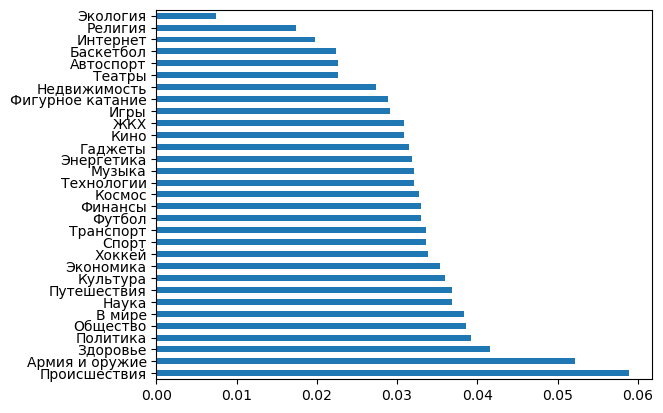

In [36]:
# Горизонтальная столбчатая диаграмма для rubric
df_nlp['rubric'].value_counts(normalize=True).plot.barh()

<AxesSubplot:>

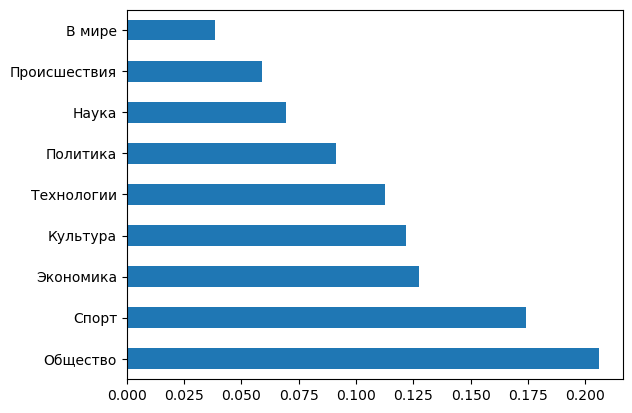

In [37]:
# Горизонтальная столбчатая диаграмма для main_rubric
df_nlp['main_rubric'].value_counts(normalize=True).plot.barh()

### Сохранение данных в формате csv

In [41]:
# Для mac
df_nlp.to_csv('ML.csv')

# Для win
#df_nlp.to_csv(r'C:\Users\User\Downloads\ML.csv')
# Выражение, добавляющее к БД только новые новости
#res = df1[~df1['url'].isin(df2['url'])]